In [2]:
import platform
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

In [77]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'
        self.df['therapy_Morps'] = self.df['therapy'].map(lambda x: self.getMorps(x))
        self.df['therapy_NV'] = self.df['therapy_Morps'].map(lambda x: self.getNV(x))
        self.df['therapy_N'] = self.df['therapy_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['therapy_count_topn_NV']  = self.df['therapy_NV'].map(lambda x: self.counter(x,n)) 
        self.df['therapy_count_topn_N']  = self.df['therapy_N'].map(lambda x: self.counter(x,n)) 

    def result(self,idx, top , dis):
        effs_dims = ['에너지', '회복', '순환', '정화']
        sNV = self.df['therapy'][idx].split(" ")
        result = []
        for dim in effs_dims:
            sub = []
            for word in sNV:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim , word))
                except:
                    sub.append(0)
            tmp = np.sort(sub)[::-1][:top].mean()
            result.append(tmp)

        
        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]
            std = np.std(result)
            
            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 대표어')
            plt.xticks(np.arange(len(effs_dims)), effs_dims)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
            print(f'{word}s std is {std}' )
        return result
        
    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_idx,figsize):
        plt.rc('font', family=self.font)
        sNV = self.df['therapy'][emotion_idx].split(" ")
        effs_dims = ['에너지', '회복', '순환', '정화']
        
        
        result = []
        for out_word in sNV:
            sub_result = []
            for in_word in effs_dims:
                try:
                    sub_result.append(self.wiki_model.wv.similarity(out_word, in_word))
                except:
                    sub_result.append(0)
            result.append(sub_result)
        
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        em_name = self.df['emotion'][emotion_idx]
        plt.title(f'{em_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(effs_dims)),effs_dims)
        plt.yticks(np.arange(len(sNV)),sNV)
        plt.show()
              
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def count_to_csv(self,file_name):
        em_name = ['행복' , '열정' , '두려움', '분노' , '우울' , '슬픔']
        em_idx = []
        for em in em_name:
            em_idx.append(em)
            em_idx.append(em + "count")
            em_idx.append(em + 'sims')
        
        em_dict = []
        max =  0
        for idx in range(0,5):
            vv = len(collections.Counter(self.df['therapy_NV'][idx]).items())
            if max < vv:
                max = vv

        ret_df = pd.DataFrame(em_dict,columns=em_idx)
        
        for idx in range(0,len(em_idx),3):
            tmp = sorted(collections.Counter(self.df['therapy_NV'][round(idx/3)]).items(), key = lambda item : item[1], reverse=True)
            tmp_words = []
            tmp_counts = []
            tmp_sims = []
            for x, y in tmp:
                tmp_words.append(x)
                tmp_counts.append(y)
                try:
                    tmp_sims.append(self.wiki_model.wv.similarity(x,em_idx[idx]))
                except:
                    tmp_sims.append(0)
            for _ in range(0,max - len(tmp)):
                tmp_words.append("")
                tmp_counts.append(0)
                tmp_sims.append(0)
                
            ret_df[em_idx[idx]] = tmp_words
            ret_df[em_idx[idx+1]] = tmp_counts
            ret_df[em_idx[idx+2]] = tmp_sims
        ret_df.to_csv(file_name)
        return ret_df
                
    def sim_word_to_csv(self,topn,file_name):
        em_name = ['행복','Similarity', '열정','Similarity', '두려움', 'Similarity', '분노','Similarity', '우울','Similarity', '슬픔','Similarity']
        em_dict = []
        
        ret_df = pd.DataFrame(em_dict,columns=em_name)
        for idx in range(0,len(em_name),2):
            
            tmp = self.wiki_model.wv.most_similar(em_name[idx],topn=topn)
            tmp_simwords = []
            tmp_Similarity = []
            
            for x , y in tmp:
                tmp_simwords.append(x)
                tmp_Similarity.append(y)
            
            ret_df[em_name[idx]] = tmp_simwords
            ret_df[em_name[idx+1]] = tmp_Similarity
        ret_df.to_csv(file_name)
        return ret_df
    
    def todf(self,topn, file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['emotion'][idx])
            est = self.result(idx,topn,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

In [83]:
h_data = pd.read_csv("../data/emotion_data_hand_craft.csv")
h_data

,emotion,therapy
0,행복,음미 향유 긍정 느낌 증폭 지속 만끽 자축 즐거움 감사
1,열정,열정 오래가다 지속 타오르다 유지 건강 목표 달리다 실행 힘 숙면 운동 계획 능률...
2,두려움,즐거움 호기심 긍정 진정
3,분노,잠재우다 호르몬 작동 내면 줄이다 멈추다 전환점 통제 비우다 회피 인정 치료 의식...
4,우울,긍정 회복 목표 운동 균형
5,슬픔,지원 건강 극복 행복


In [82]:
# 상위 N개 설정
topn = 1

In [127]:
hXYZ = check_data(h_data)
std_test = hXYZ.todf(topn,"../result/emotion_estimation_hand_craft.csv")
std_test

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


,감정,에너지,회복,순환,정화
0,행복,0.300379,0.469413,0.287386,0.282726
1,열정,1.000000,0.598599,0.395890,0.400756
2,두려움,0.140877,0.477591,0.057623,0.300837
3,분노,0.364110,0.405571,0.323333,0.367194
4,우울,0.341376,1.000000,0.250951,0.360276
5,슬픔,0.191463,0.461462,0.185052,0.320086


In [132]:
mean_std = []
for em , *est in np.array(std_test):
    std = np.std(est)
    mean_std.append(std)
    print(std)

print('각 item의 분산에 대한 평균: \n{}'.format(np.mean(mean_std)))

0.07788628781429328
0.24563971119196518
0.16059700531185125
0.029102264793564113
0.2983906835023195
0.11294611430129681
각 item의 분산에 대한 평균: 
0.15409367781921504


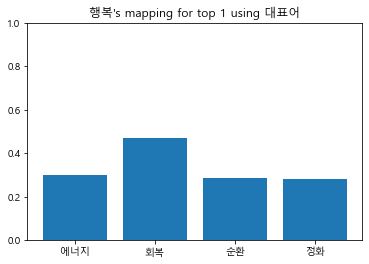

행복s std is 0.07788628781429328


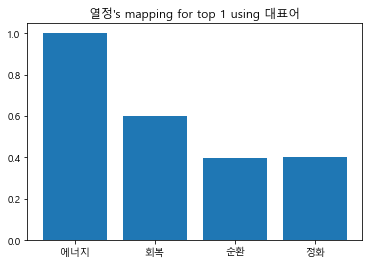

열정s std is 0.24563971119196518


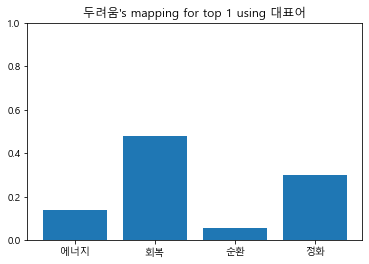

두려움s std is 0.16059700531185125


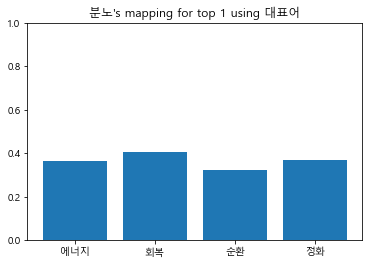

분노s std is 0.029102264793564113


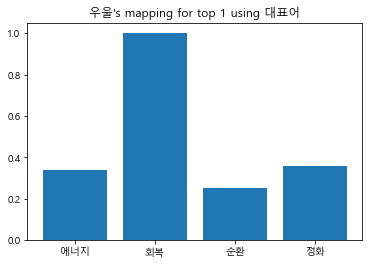

우울s std is 0.2983906835023195


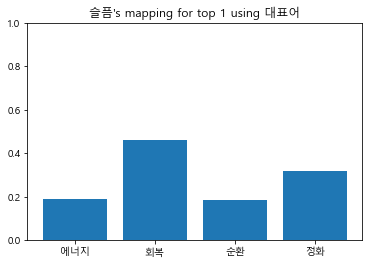

슬픔s std is 0.11294611430129681


In [85]:
# 상위 N개에 대한 평균 시각화
for i in h_data.index:
    hXYZ.result(i,topn,True)


In [140]:
def choose_topn(topn):
    hXYZ = check_data(h_data)
    std_test = hXYZ.todf(topn,"../result/emotion_estimation_hand_craft.csv")

    mean_std = []
    for em , *est in np.array(std_test):
        std = np.std(est)
        mean_std.append(std)
        #print(std)

    print('각 item의 분산에 대한 평균: {}'.format(np.mean(mean_std)))


In [142]:
for idx in range(1,10):
    choose_topn(idx)

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.15409367781921504


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.09931957488877645


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.0800200083680485


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.06913789679018369


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.06222129132668077


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.05736308858457891


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.054679760168792745


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


각 item의 분산에 대한 평균: 0.05246748493092853
각 item의 분산에 대한 평균: 0.050671420409547675


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


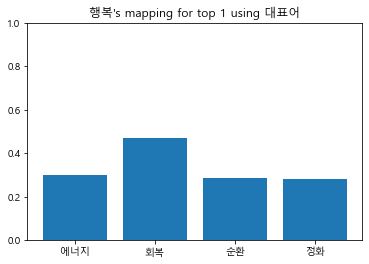

행복s std is 0.07788628781429328


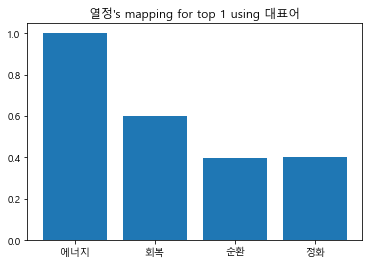

열정s std is 0.24563971119196518


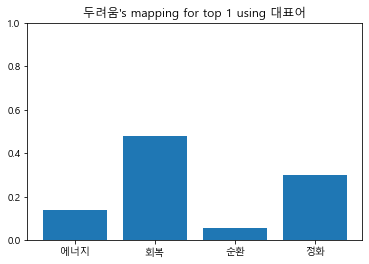

두려움s std is 0.16059700531185125


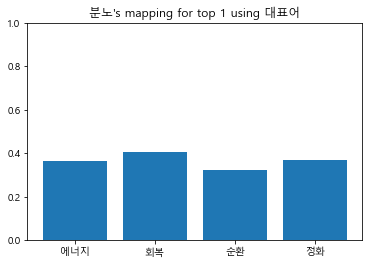

분노s std is 0.029102264793564113


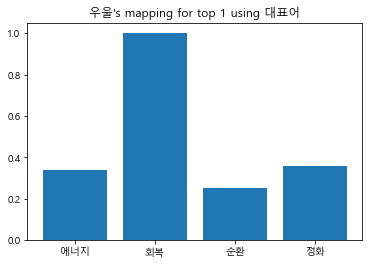

우울s std is 0.2983906835023195


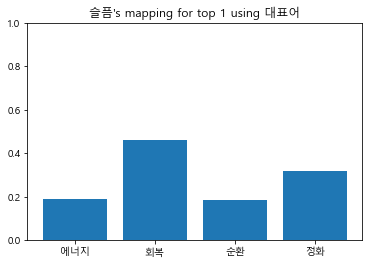

슬픔s std is 0.11294611430129681


In [143]:
# 상위 1개에 대한 평균 시각화
for i in h_data.index:
    hXYZ.result(i,1,True)


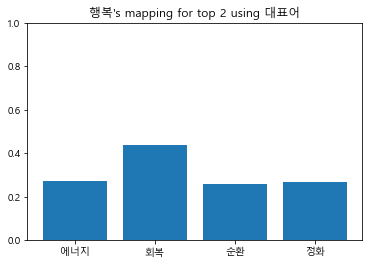

행복s std is 0.07554359760721789


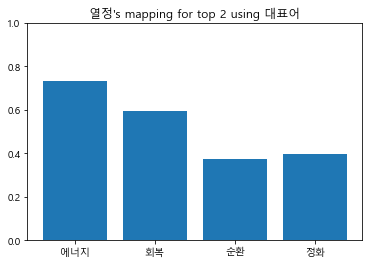

열정s std is 0.14714967208971266


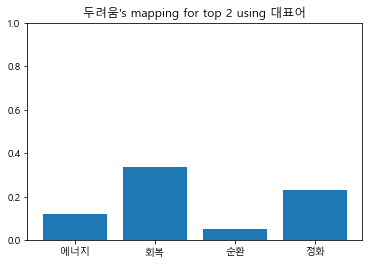

두려움s std is 0.1088578240877475


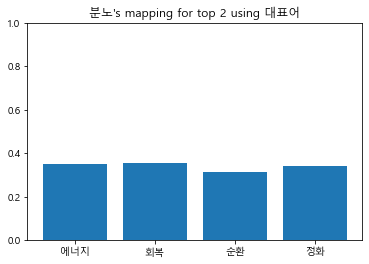

분노s std is 0.0162855837028474


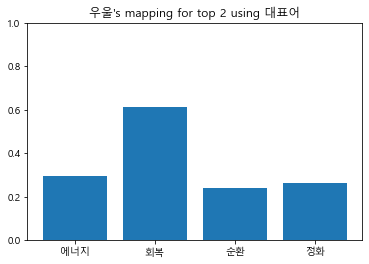

우울s std is 0.15141547405679814


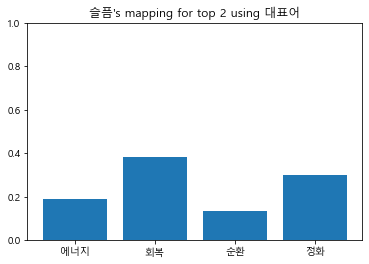

슬픔s std is 0.09666529778833513


In [144]:
# 상위 1개에 대한 평균 시각화
for i in h_data.index:
    hXYZ.result(i,2,True)
